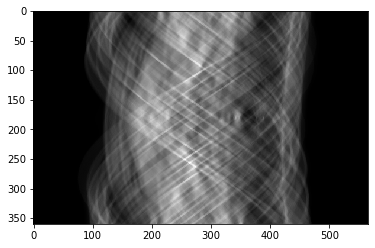

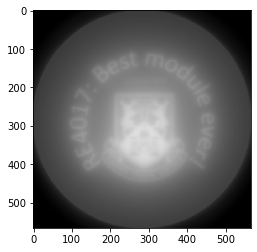

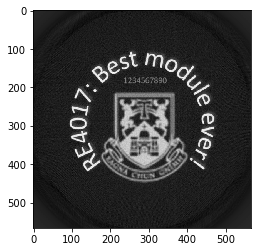

In [2]:
'''
#Students Name's:  	Ciaran Carroll
# Student Id Number's:	13113259
#
# Project 1:
# Implement image reconstruction from parallel-projection sinograms using Python.
#
# CAT Scanners (or CT scan) - Computer Axial Tomography
# CT scan: is a special X-ray tests that produce cross-sectional images of the body using X-rays and
#          a computer
# FFTs - Fast Fourieris Transform
# FFT: is an algorithm that samples a signal over a period of time (or space) and divides it
#      into its frequency components
# Laminogram: Reconstruct the sum of the backprojections (i.e. sum of the f(x,y))
# Coplanar rotational laminography (CRL) is a special case of laminography which is a
#  tomographic technique used to image cross-sectional views through solid objects.
#
# Aim:
# (1) Reconstruct an image from the sinogram image (sinogram.png)
# (2) Investigate the behaviour of backprojection reconstruction with ramp-filtering
# (3) Investigate the behaviour of backprojection reconstruction without ramp-filtering
# (4) Investigate the behaviour of backprojection reconstruction with Hamming-windowed ramp-filtering
#
# A display of all the projections for all X-ray angles is called a Sinogram
#
# Rebuild the image from a sum of the 'Backprojections' of the 1-d projection data

Step 1 - Backprojection reconstruction of the sinogram without filtering:
When all the projection angles are combined the projection, the resulting image will
be blurred. This is due to the fact that the resulting image is concentrated towards the
center. (concentrated samples of the image towards the center, and more sparse samples near
the edges). To compensate for this we will need to apply a filter to the output image of the
backprojection such as the ramp filter or the Hamming-windowed ramp-filter








New Steps
(1) - Form the image projections and translate into the frequency domain using the FFT


'''

import numpy as np
import matplotlib.pylab as plt
from PIL import Image
from scipy.ndimage.filters import gaussian_filter
from skimage.transform import rotate
import scipy.fftpack as fft
#from skimage.transform import iradon

def imread(filename,greyscale=True):
    """Load an image, return as a Numpy array."""
    if greyscale:
        pil_im = Image.open(filename).convert('L')
    else:
        pil_im = Image.open(filename)
    return np.array(pil_im)


def imshow(im, autoscale=False,colourmap='gray', newfig=True, title=None):
    """Display an image, turning off autoscaling (unless explicitly required)
       and interpolation.

       (1) 8-bit greyscale images and 24-bit RGB are scaled in 0..255.
       (2) 0-1 binary images are scaled in 0..1.
       (3) Float images are scaled in 0.0..1.0 if their min values are >= 0
           and their max values <= 1.0
       (4) Float images are scaled in 0.0..255.0 if their min values are >= 0
           and their max values are > 1 and <= 255.0
       (5) Any image not covered by the above cases is autoscaled.  If
           autoscaling is explicitly requested, it is always turned on.

       A new figure is created by default.  "newfig=False" turns off this
       behaviour.

       Interpolation is always off (unless the backend stops this).
    """
    if newfig:
        if title != None: fig = plt.figure(title)
        else: fig = plt.figure()
    if autoscale:
        plt.imshow(im,interpolation='nearest',cmap=colourmap)
    else:
        maxval = im.max()
        if im.dtype == 'uint8':        ## 8-bit greyscale or 24-bit RGB
            if maxval > 1: maxval = 255
            plt.imshow(im,interpolation='nearest',vmin=0,vmax=maxval,cmap=colourmap)
        elif im.dtype == 'float32' or im.dtype == 'float64':
            minval = im.min()
            if minval >= 0.0:
                if maxval <= 1.0:  ## Looks like 0..1 float greyscale
                    minval, maxval = 0.0, 1.0
                elif maxval <= 255.0: ## Looks like a float 0 .. 255 image.
                    minval, maxval = 0.0, 255.0
            plt.imshow(im,interpolation='nearest',vmin=minval,vmax=maxval,cmap=colourmap)
        else:
            plt.imshow(im,interpolation='nearest',cmap=colourmap)
    plt.axis('image')
    ## plt.axis('off')
    plt.show()
    ##return fig

def build_proj_ffts(projs):
    "Build 1-d FFTs of an array of projections, each projection 1 row fo the array."

    return fft.rfft(projs, axis=1)

def build_proj_iffts(projs):
    "Build 1-d iFFTs of an array of projections, each projection 1 row fo the array."

    return fft.irfft(projs, axis=1)

def build_laminogram(radonT):
    "Generate a laminogram by simple backprojection using the Radon Transform of an image, 'radonT'."
    laminogram = np.zeros((radonT.shape[1],radonT.shape[1]))
    dTheta = 180.0 / radonT.shape[0]
    for i in range(radonT.shape[0]):
        temp = np.tile(radonT[i],(radonT.shape[1],1))
        temp = rotate(temp, dTheta*i)
        laminogram += temp
    return laminogram

def ramp_filter_ffts(ffts):
    "Ramp filter a 2-d array of 1-d FFTs (1-d FFTs along the rows)."
    ramp = np.floor(np.arange(0.5, ffts.shape[1]//2 + 0.1, 0.5))
    return ffts * ramp

def radon(image, steps):
    "Build the Radon Transform using 'steps' projections of 'image’."
    projections = []        # Accumulate projections in a list.
    dTheta = -180.0 / steps # Angle increment for rotations.
    for i in range(steps):
        projections.append(rotate(image, i*dTheta).sum(axis=0))
    return np.vstack(projections)

# Original Sinogram Image
sinogram = imread('sinogram.png')
imshow(sinogram, title="Original Sinogram Image")

# Backprojection reconstruction without ramp filtering
sinogram_laminogram = build_laminogram(sinogram)
imshow(sinogram_laminogram, title="Sinogram reconstruction by backprojection")

# Backprojection reconstruction with ramp filtering

# Apply an infinite ramp filter to the reconstruction

#  Maybe apply a ramp filter with a cutoff at half the max frwquency
# But most likely no point

# Get the FFT of the image (Frequency Domain)
fourier = build_proj_ffts(sinogram)

# Filter the fourier transform by the ramp filter
ramp_filtered = ramp_filter_ffts(fourier)

# Take the inverse FFT of the image to convert it back to Special Domain
inverse_fourier_ramp_filtered = build_proj_iffts(ramp_filtered)
#imshow(iffts_projection_sinogram, title="Test ramp filter")
#test1 = radon(iffts_projection_sinogram, 180)
#imshow(test1, title="Test ramp filter")

# Build the filtered image by pbackprojecting the filtered projections
filtered_reconstrution = build_laminogram(inverse_fourier_ramp_filtered)
imshow(filtered_reconstrution, title="Test ramp filter")
